# Global

In [1]:
global_var = {
    # Data
    'data_path': "/content/vessel_data",
    'prefix': "https://drive.google.com/uc?export=",
    'bifurcating_data_id': "download&id=1bzXusjOMgh-5hnw6RDNc03UUktQixtL4",
    'single_data_id': "download&id=19AHhDU1UWBzpG33wlB1r7b6sH3lMVly5",
    'current_name': "bifurcating",

    # Datasets
    'single_path': "./single/single.hdf5",
    'bifurcating_path': "./bifurcating/bifurcating.hdf5",
    'dataset_path': "./dataset.hdf5",
    'train_path': "./train.hdf5",
    'test_path': "./test.hdf5",
    'data_crop': 5466,

    # Datasets quality check
    'data_length': 2000,
    'bases': 3,
    'data_keys': ['face', 'inlet_idcs', 'pos', 'pressure', 'wss'],

    # Geometric algebra
    'ga_dimension': 16,
    'grade_components': [1,4,6,4,1],

    # Train
    'train_test_split': 0.8,
    'validation_split': 0.1,
    'batch_size': 32,
    'num_workers': 2,
    'hidden_dim': 16,
}

# Imports

In [2]:
!pip install wget pytorch_lightning torchvision --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 19.3 MB/s eta 0:00:00


In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as pkl
import pytorch_lightning as pl
import pandas as pd
import re
import sys
import torch
import torch.nn as nn
import wget
import zipfile

from IPython.display import HTML
from pytorch_lightning import LightningModule
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

# Utils

In [4]:
def data_sanity_check(input_data,output_data):
    """
    Check for NaN and Inf values in input and output data.

    Args:
        input_data (tensor): Input data.
        output_data (tensor): Output data.

    Returns:
        None: Prints logs indicating the presence of NaN or Inf values.
    """

    input_nan = np.isnan(input_data.detach().numpy()).any()
    if input_nan:
        print("[LOG] \033[1mNan detected in input data\033[0m \u2718")
        return

    input_inf = np.isinf(input_data.detach().numpy()).any()
    if input_inf:
        print("[LOG] \033[1mInf detected in input data\033[0m \u2718")
        return

    output_nan = np.isnan(output_data.detach().numpy()).any()
    if output_nan:
        print("[LOG] \033[1mNan detected in output data\033[0m \u2718")
        return

    output_inf = np.isinf(output_data.detach().numpy()).any()
    if output_inf:
        print("[LOG] \033[1mInf detected in output data\033[0m \u2718")
        return

    print("[LOG] \033[1mData are free of infinite or Nan values\033[0m \u2714")

# Dataset

## Download datasets

In [5]:
def bar_progress(current,total,width = 80):
    """
        Simple bar to track the download list of links
        associated with patches in the dataset

        Args:
            current: current byte number
            total: total byte number
            width: visual length of the bar
    """
    progress = current / total * 100
    progress_string = f"{progress} % [{current} / {total}] bytes"
    name = global_var['current_name']
    description = f"[{name}] Recovering links: " + progress_string
    sys.stdout.write("\r" + description)
    sys.stdout.flush()

In [6]:
def get_links_list(list_link,dataset_name):
    """
        Download the file with the links referred to
        the dataset patches

        Args:
            list_link: link from where to download the file
            dataset_name: final dataset name used for log

        Returns:
            links: list of the zipped dataset patches
    """
    global_var['current_name'] = dataset_name
    list_name = wget.download(list_link,bar = bar_progress)
    links = pkl.load(open(list_name, 'rb'))
    os.remove(list_name)
    os.makedirs(dataset_name, exist_ok = True)

    return links

In [7]:
def unzip_data_patches(links,dataset_name,debug):
    """
        Unzip the downloaded file patches to obtain the respective HDF5
        file within them, cleaning up excess files when finished

        Args:
            links: list with the links referred to file to download
            dataset_name: final dataset name used for log
            debug: boolean that allow testing the function

        Returns:
            hdf5_patches: list of HDF5 files
    """
    cnt = 0 if debug else None
    hdf5_patches = []

    tqdm_desc = f"[{dataset_name}] Downloading and unzipping data patches"
    for link in tqdm(links,desc = tqdm_desc):
        name = wget.download(link)
        with zipfile.ZipFile(name, 'r') as zip_ref:
            zip_ref.extractall("/content/")
            hdf5_patches.append(name.replace(".zip",".hdf5"))
            os.remove(name)
            if debug:
                cnt +=1
            if debug and cnt > 3:
                break
    return hdf5_patches

In [8]:
def compose_dataset(dataset_file,dataset_name,hdf5_patches):
    """
        Merge several HDF5 files into one,

        Args:
            dataset_file: final dataset path
            dataset_name: final dataset name
            hdf5_patches: list of file to merge
    """
    with h5py.File(dataset_file, 'w') as file_dest:
        tqdm_desc = f"[{dataset_name}] Composing HDF5 full dataset"
        for file_origine in tqdm(hdf5_patches,desc = tqdm_desc):
            percorso_file_origine = os.path.join("/content/", file_origine)

            with h5py.File(percorso_file_origine, 'r') as file_orig:
                for gruppo_nome, gruppo in file_orig.items():
                    gruppo_dest = file_dest.create_group(gruppo_nome)

                    for data_name, dataset in gruppo.items():
                        gruppo_dest.create_dataset(data_name, data=dataset[()])

    for file in hdf5_patches:
        percorso_file = os.path.join("/content/", file)
        os.remove(percorso_file)

In [9]:
def quality_check(dataset_file,dataset_name):
    """
        Check that the final dataset meets the standards

        Args:
            dataset_file: final dataset path
            dataset_name: final dataset name used for log

        Returns:
            (Boolean): logical result of the check
    """
    print(f"[{dataset_name}]\033[1m Dataset quality check \033[0m")

    with h5py.File(dataset_file, 'r') as dataset:
        # Check correct length
        len_condition = (len(dataset) == global_var['data_length'])
        if len_condition:
            error_str = "All samples present in the dataset \u2714"
            print(f"[{dataset_name}] " + error_str)
        else:
            missing_samples = global_var['data_length'] - len(dataset)
            error_str = "Not all samples are in the dataset \u2718"
            print(f"[{dataset_name}] " + error_str)
            if missing_samples > 1:
                print(f"[{dataset_name}] \t -> {missing_samples} is missing")
            else:
                print(f"[{dataset_name}] \t -> {missing_samples} are missing")
            return False

        # Check correct keys
        keys_condition = True
        for sample in list(dataset.keys()):
            correct_keys = list(dataset[sample].keys())
            current_keys = global_var['data_keys']
            keys_condition = keys_condition and (correct_keys == current_keys)
            if not keys_condition:
                problematic_sample = sample
                break
        if keys_condition:
            print(f"[{dataset_name}] All samples keys are correct \u2714")
        else:
            print(f"[{dataset_name}] Error in samples keys \u2718")
            print(f"[{dataset_name}] \t -> Check {problematic_sample}")
            return False

        # Check correct ordering
        ordering_condition = True
        numbers = [re.search(r'_\d+', s).group()[1:] for s in dataset.keys()]
        for n in range(len(numbers)):
            counter = f'{n:04d}'
            ordering_condition = ordering_condition and (numbers[n] == counter)
            if numbers[n] != counter:
                problematic_sample = counter
            break

        if ordering_condition:
            print(f"[{dataset_name}] Samples are ordered \u2714")
        else:
            print(f"[{dataset_name}] Samples are NOT ordered \u2718")
            print(f"[{dataset_name}] \t -> Check {counter}")
            return False

    return True

In [10]:
def download_dataset(list_link, dataset_name, debug):
    """
        Download the dataset divided into several patches,
        assemble it and check that the operation is successful

        Args:
            list_link: link from where to download the file
            dataset_name: final dataset name used for log
            debug: boolean that allow testing the function
    """
    dataset_file = dataset_name + "/" + dataset_name + ".hdf5"
    if not os.path.exists(dataset_name):
        links = get_links_list(list_link,dataset_name)
        hdf5_patches = unzip_data_patches(links,dataset_name,debug)
        compose_dataset(dataset_file,dataset_name,hdf5_patches)
        check = quality_check(dataset_file,dataset_name)

        if check:
            success_string = "Dataset correctly downloaded \033[0m\u2714"
            print(f"[{dataset_name}] \u2714\033[1m " + success_string)
        else:
            error_string = "Dataset download failed \033[0m\u2718"
            print(f"[{dataset_name}] \u2718\033[1m " + error_string)
    else:
        done_string = f"Dataset is already available in {dataset_file}"
        print(f"[{dataset_name}] " + done_string)

In [11]:
bifurcating_link = global_var['prefix'] + global_var["bifurcating_data_id"]
download_dataset(
    list_link = bifurcating_link,
    dataset_name = "bifurcating",
    debug = False
)

[bifurcating] Recovering links: 100.0 % [8708 / 8708] bytes

[bifurcating] Downloading and unzipping data patches:   0%|          | 0/100 [00:00<?, ?it/s]

[bifurcating] Composing HDF5 full dataset:   0%|          | 0/100 [00:00<?, ?it/s]

[bifurcating] Dataset quality check 
[bifurcating] All samples present in the dataset ✔
[bifurcating] All samples keys are correct ✔
[bifurcating] Samples are ordered ✔
[bifurcating] ✔ Dataset correctly downloaded ✔


In [12]:
single_link = global_var['prefix'] + global_var["single_data_id"]
download_dataset(
    list_link = single_link,
    dataset_name = "single",
    debug = False
)

[single] Recovering links: 100.0 % [8708 / 8708] bytes

[single] Downloading and unzipping data patches:   0%|          | 0/100 [00:00<?, ?it/s]

[single] Composing HDF5 full dataset:   0%|          | 0/100 [00:00<?, ?it/s]

[single] Dataset quality check 
[single] All samples present in the dataset ✔
[single] All samples keys are correct ✔
[single] Samples are ordered ✔
[single] ✔ Dataset correctly downloaded ✔


## Train and test data

In [13]:
def copy_data(source, destination, new_sample, old_sample, label):
    """
    Copy data from a source HDF5 group to a destination HDF5 group.

    Args:
        source (h5py.Group): Source HDF5 group.
        destination (h5py.Group): Destination HDF5 group.
        new_sample (str): Name of the new sample in the destination group.
        old_sample (str): Name of the old sample in the source group.
        label: Label for the new sample.

    Returns:
        None: Copies data and creates a new sample in the destination group.
    """
    destination.create_group(new_sample)
    for field in list(source[old_sample].keys()):
        new_field_data = source[old_sample][field][()]
        destination[new_sample].create_dataset(field, data = new_field_data)

    destination[new_sample].create_dataset('label', data = np.array([label]))

In [14]:
def shuffle_dataset(temp_dataset,dataset):
    """
    Shuffle the samples in a dataset and create a new shuffled HDF5 file.

    Args:
        temp_dataset (str): Path to the temporary HDF5 file.
        dataset (str): Path to the destination HDF5 file.

    Returns:
        None: Creates a new shuffled HDF5 file and removes the temporary file.
    """
    with h5py.File(temp_dataset, 'r') as file:
        # Extract group names (assuming they are 'sample_0000', etc.)
        sample_names = list(file.keys())

        # Shuffle indices
        shuffled_indices = np.random.permutation(len(sample_names))

        # Create a new shuffled HDF5 file
        with h5py.File(dataset, 'w') as shuffled_file:
            values = enumerate(shuffled_indices)
            iters = len(shuffled_indices)
            shuffle_desc = '[LOG] Shuffling dataset'

            for new_index, old_index in tqdm(
                values,
                total = iters,
                desc = shuffle_desc
            ):
                sample = f'sample_{new_index:04d}'
                old_name = f'sample_{old_index:04d}'
                shuffled_file.create_group(sample)
                for field in file[old_name]:
                    shuffled_file[sample][field] = file[old_name][field][()]

    os.remove(temp_dataset)

In [15]:
def train_test_split(dataset):
    """
    Split the dataset into training and test sets and create new HDF5 files.

    Args:
        dataset (str): Path to the original HDF5 file.

    Returns:
        None: Creates new HDF5 files for the training and test sets, and removes the original file.
    """
    with h5py.File(dataset, 'r') as file:
        total_rows = len(file)

        # Calculates the number of rows for each set
        train_rows = int(global_var['train_test_split'] * total_rows)
        test_rows = total_rows - train_rows

        if not os.path.exists(global_var['train_path']):
            # Create a new HDF5 file for the training set
            with h5py.File(global_var['train_path'], 'w') as train_file:
                iters = range(train_rows)
                train_desc = "[LOG] Composing train set"

                for i in tqdm(iters,desc = train_desc):
                    sample = f'sample_{i:04d}'
                    train_file.create_group(sample)

                    for field in file['sample_0000']:
                        train_file[sample][field] = file[sample][field][()]

        if not os.path.exists(global_var['test_path']):
            # Create a new HDF5 file for the test set
            with h5py.File(global_var['test_path'], 'w') as test_file:
                iters = range(train_rows, total_rows)
                test_desc = "[LOG] Composing test set"

                for i in tqdm(iters,desc = test_desc):
                    sample = f'sample_{i:04d}'
                    test_file.create_group(f'sample_{i:04d}')

                    for field in file['sample_0000']:
                        sample = f'sample_{i:04d}'
                        test_file[sample][field] = file[sample][field][()]

    os.remove(dataset)

In [16]:
def merge_datasets(single_path,bifurcating_path,debug = False):
    """
    Merge single and bifurcating datasets, copy data, shuffle, and split into train and test sets.

    Args:
        single_path (str): Path to the single dataset.
        bifurcating_path (str): Path to the bifurcating dataset.
        debug (bool): Debug mode flag.

    Returns:
        None: Merges datasets, copies data, shuffles, and splits into train and test sets.
    """
    train_condition = os.path.exists(global_var['train_path'])
    test_condition = os.path.exists(global_var['test_path'])
    start_condition =  train_condition and test_condition

    if debug or not start_condition:
        with h5py.File(single_path, 'r') as single, \
            h5py.File(bifurcating_path, 'r') as bifurcating:
            signle_len = range(len(single))
            bifurcating_len = range(len(bifurcating))

            dataset_path = global_var['dataset_path']
            temp_dataset = dataset_path.replace(".hdf5", "_temp.hdf5")
            with h5py.File(temp_dataset, 'w') as dataset:
                single_desc = "[single] Copying data"
                for single_idx in tqdm(signle_len, desc = single_desc):
                    sample_name = f'sample_{single_idx:04d}'
                    label = 0
                    copy_data(
                        source = single,
                        destination = dataset,
                        new_sample = sample_name,
                        old_sample = sample_name,
                        label = label
                     )

                bifurcating_desc = "[bifurcating] Copying data"
                for bif_idx in tqdm(bifurcating_len, desc = bifurcating_desc):
                    sample_name = f'sample_{bif_idx + 2000:04d}'
                    old_sample_name = f'sample_{bif_idx:04d}'
                    label = 1
                    copy_data(
                        source = bifurcating,
                        destination = dataset,
                        new_sample = sample_name,
                        old_sample = old_sample_name,
                        label = label
                     )

        shuffle_dataset(temp_dataset,global_var['dataset_path'])
        train_test_split(global_var['dataset_path'])
    else:
        print("[LOG] Train and test sets already available")

In [17]:
merge_datasets(
    single_path = global_var['single_path'],
    bifurcating_path = global_var['bifurcating_path'],
    debug = True
)

[single] Copying data:   0%|          | 0/2000 [00:00<?, ?it/s]

[bifurcating] Copying data:   0%|          | 0/2000 [00:00<?, ?it/s]

[LOG] Shuffling dataset:   0%|          | 0/4000 [00:00<?, ?it/s]

[LOG] Composing train set:   0%|          | 0/3200 [00:00<?, ?it/s]

[LOG] Composing test set:   0%|          | 0/800 [00:00<?, ?it/s]

## Embedding in geometric algebra

In [18]:
def get_pos_mv(pos):
    """
    Embed the (n_items,3) position vector in geometric algebra

    Args:
        pos (torch.Tensor): Input position tensor.

    Returns:
        torch.Tensor: Embed of the position vector in geometric algebra
    """
    n_items, dimension = pos.shape
    reshaped_pos = pos.reshape(1,n_items,1,dimension)

    mv_shape = reshaped_pos.shape[:3]
    mv = torch.zeros(*mv_shape, global_var['ga_dimension'])

    mv[..., 14] = 1 # homogeneous coordinates
    mv[..., 11] = reshaped_pos[..., 0] # x-coordinate of pos
    mv[..., 12] = reshaped_pos[..., 1] # y-coordinate of pos
    mv[..., 13] = reshaped_pos[..., 2] # z-coordinate of pos

    return mv

In [19]:
def get_face_mv(face):
    """
    Embed the (n_items,3) faces vector in geometric algebra

    Args:
        face (torch.Tensor): Input faces tensor.

    Returns:
        torch.Tensor: Embed of the faces vector in geometric algebra
    """
    n_items, dimension = face.shape
    reshaped_face = face.reshape(1,n_items,1,dimension)

    mv_shape = reshaped_face.shape[:3]
    mv = torch.zeros(*mv_shape, global_var['ga_dimension'])

    mv[..., 2] = reshaped_face[..., 0]
    mv[..., 3] = reshaped_face[..., 1]
    mv[..., 4] = reshaped_face[..., 2]

    return mv

In [20]:
def get_wss_mv(wss):
    """
    Embed the (n_items,3) wss vector in geometric algebra

    Args:
        pos (torch.Tensor): Input wss tensor.

    Returns:
        torch.Tensor: Embed of the wss vector in geometric algebra
    """
    n_items, dimension = wss.shape
    reshaped_wss = wss.reshape(1,n_items,1,dimension)

    mv_shape = reshaped_wss.shape[:3]
    mv = torch.zeros(*mv_shape, global_var['ga_dimension'])

    mv[..., 0] = 1 # homogeneous coordinates

    mv[..., 5] = 0.5 * reshaped_wss[..., 0]
    mv[..., 6] = 0.5 * reshaped_wss[..., 1]
    mv[..., 7] = 0.5 * reshaped_wss[..., 2]

    return mv

In [21]:
def get_inlet_mv(inlet):
    """
    Embed the (n_items,) inlet vector in geometric algebra

    Args:
        pos (torch.Tensor): Input inlet tensor.

    Returns:
        torch.Tensor: Embed of the inlet vector in geometric algebra
    """
    n_items = inlet.shape[0]
    reshaped_inlet = inlet.reshape(1,n_items,1,1)

    mv_shape = reshaped_inlet.shape[:3]
    mv = torch.zeros(*mv_shape, global_var['ga_dimension'])

    mv[..., 0] = reshaped_inlet[...,0]

    return mv

In [22]:
def get_pressure_mv(pressure):
    """
    Embed the (n_items,) pressures vector in geometric algebra

    Args:
        pos (torch.Tensor): Input pressures tensor.

    Returns:
        torch.Tensor: Embed of the pressures vector in geometric algebra
    """
    n_items = pressure.shape[0]
    reshaped_pressure = pressure.reshape(1,n_items,1,1)

    mv_shape = reshaped_pressure.shape[:3]
    mv = torch.zeros(*mv_shape, global_var['ga_dimension'])

    mv[..., 0] = reshaped_pressure[...,0]

    return mv

In [23]:
def embed_data(sample):
    """
    Embed data properties into a multivector

    Args:
        sample (dict): Dataset sample

    Returns:
        torch.Tensor: Sample proprietries embedded in geometric
                        algebra via multivector
    """
    # 'pos' property modeled as a point
    cropped_pos = sample['pos'][:global_var['data_crop']]
    input_pos = torch.tensor(np.array(cropped_pos))
    pos_mv = get_pos_mv(input_pos)

    # 'face' property modeled as a plane
    cropped_face = sample['face'][:global_var['data_crop']]
    input_face = torch.tensor(np.array(cropped_face))
    face_mv = get_face_mv(input_face)

    # 'wss' property modeled as a translation
    cropped_wss = sample['wss'][:global_var['data_crop']]
    input_wss = torch.tensor(np.array(cropped_wss))
    wss_mv = get_wss_mv(input_wss)

    # 'pressure' modeled as a scalar
    cropped_pressure = sample['pressure'][:global_var['data_crop']]
    input_pressure = torch.tensor(np.array(cropped_pressure))
    pressure_mv = get_pressure_mv(input_pressure)

    # (batch,n_items,sample_features,ga_dimension)
    total_mvs = torch.cat([pos_mv, face_mv, wss_mv, pressure_mv],dim = 2)

    return total_mvs

## Pytorch dataset

In [24]:
class VesselDataset(Dataset):
    """
    Dataset class for vessel data.

    Args:
        file_path (str): Path to the HDF5 file containing vessel data.
    """
    def __init__(self, file_path):
        self.file_path = file_path
        self.transform = transforms.Compose([embed_data])
        with h5py.File(file_path, 'r') as file:
            self.sample_names = list(file.keys())

    def __len__(self):
        return len(self.sample_names)

    def __getitem__(self, index):
        sample_name = self.sample_names[index]

        with h5py.File(self.file_path, 'r') as file:
            multivector = self.transform(file[sample_name]).squeeze(0)
            label = torch.tensor(file[sample_name]['label'][()])

        return multivector,label

## Lightning DataModule

In [25]:
class VesselDataModule(pl.LightningDataModule):
    """
    Lightning DataModule for Vessel data.

    Args:
        bifurcating_path (str): Path to bifurcating dataset.
        single_path (str): Path to single dataset.
        train_path (str): Path to train dataset.
        test_path (str): Path to test dataset.
    """
    def __init__(self,bifurcating_path,single_path,train_path,test_path):
        super().__init__()
        self.bifurcating_path = bifurcating_path
        self.single_path = single_path
        self.train_path = train_path
        self.test_path = test_path

    def prepare_data(self):
        id = global_var['bifurcating_data_id']
        bifurcating_link = global_var['prefix'] + id
        download_dataset(
            list_link = bifurcating_link,
            dataset_name = "bifurcating",
            debug = False
         )
        id = global_var['single_data_id']
        single_link = global_var['prefix'] + id
        download_dataset(
            list_link = single_link,
            dataset_name = "single",
            debug = False
         )
        merge_datasets(
            single_path = self.single_path,
            bifurcating_path = self.bifurcating_path,
            debug = False
         )

    def setup(self, stage = None):
        if stage == "fit" or stage is None:
            train_dataset = VesselDataset(self.train_path)
            train_len = train_dataset.__len__()
            validation_len = int(train_len * global_var['validation_split'])
            train_val_split = [train_len - validation_len,validation_len]

            splitted_data = random_split(train_dataset, train_val_split)
            self.data_train, self.data_val = splitted_data

        if stage == "test" or stage is None:
            self.data_test = VesselDataset(self.test_path)

        if stage == "predict" or stage is None:
            pass

    def train_dataloader(self):
        return DataLoader(
            self.data_train,
            shuffle = True,
            batch_size = global_var['batch_size'],
            num_workers = global_var['num_workers']
         )

    def val_dataloader(self):
        return DataLoader(
            self.data_val,
            shuffle = True,
            batch_size = global_var['batch_size'],
            num_workers = global_var['num_workers']
         )

    def test_dataloader(self):
        return DataLoader(
            self.data_test,
            shuffle = True,
            batch_size = global_var['batch_size'],
            num_workers = global_var['num_workers']
         )

    def predict_dataloader(self):
        return None

In [26]:
data_module = VesselDataModule(
    bifurcating_path = global_var['bifurcating_path'],
    single_path = global_var['single_path'],
    train_path = global_var['train_path'],
    test_path = global_var['test_path']
)

# EDA

## Data statistics

In [27]:
def data_statistics(file_path):
    """
    Display descriptive statistics for various properties in the dataset.

    Args:
        file_path (str): Path to the HDF5 file.

    Returns:
        None: Displays the descriptive statistics.
    """
    with h5py.File('train.hdf5', 'r') as file:
        wss_values = file['sample_0000']['wss'][:]
        pressure_values = file['sample_0000']['pressure'][:]
        position_values = file['sample_0000']['pos'][:]
        faces_values = file['sample_0000']['face'][:]
        inlet_idcs_values = file['sample_0000']['inlet_idcs'][:]

    df_pressure = pd.DataFrame(
        pressure_values * 1e-3,
        columns = ['Pressure']
    ).describe()

    df_wss = pd.DataFrame(
        wss_values,
        columns = ['WSS_x', 'WSS_y', 'WSS_z']
    ).describe()

    df_position = pd.DataFrame(
        position_values,
        columns = ['Position_x', 'Position_y', 'Position_z']
    ).describe()

    df_face = pd.DataFrame(
        faces_values,
        columns = ['Face_x', 'Face_y', 'Face_z']
    ).describe()

    df_inlet = pd.DataFrame(
        inlet_idcs_values,
        columns = ['Inlet']
    ).describe()

    df = pd.concat([
        df_pressure,
        df_wss,
        df_position,
        df_face,
        df_inlet
    ],axis = 1)

    df.iloc[1:] = df.iloc[1:].applymap('{:.4f}'.format)
    display(df)

In [28]:
data_statistics(global_var['train_path'])

,Pressure,WSS_x,WSS_y,WSS_z,Position_x,Position_y,Position_z,Face_x,Face_y,Face_z,Inlet
count,10663.0,10663.0,10663.0,10663.0,10663.0,10663.0,10663.0,21322.0,21322.0,21322.0,272.0
mean,134.3238,19.3894,2.9530,0.0288,2.1091,0.3276,-0.0007,4939.2676,6056.0923,4953.4056,9716.2390
std,0.7973,26.3421,11.7298,3.8862,2.3690,0.5164,0.1341,2936.0711,3180.2842,2956.8628,1530.9077
min,132.9994,-13.5272,-105.0615,-38.2205,-1.9290,-0.5121,-0.1953,0.0000,0.0000,0.0000,5308.0000
25%,133.6202,13.7889,-3.8284,-0.1894,0.0660,-0.1042,-0.1305,2414.0000,3233.2500,2408.0000,10266.2500
50%,133.8283,15.1989,2.0215,0.0000,2.0795,0.2580,0.0004,4859.0000,6420.5000,4872.5000,10401.5000
75%,135.0728,17.4543,6.3783,0.1865,4.1584,0.6712,0.1300,7342.0000,9064.7500,7374.0000,10543.2500
max,136.4701,332.7823,82.5989,38.0790,6.0854,1.5570,0.1953,10662.0000,10662.0000,10662.0000,10662.0000


## Data shapes

In [29]:
def data_shapes():
    """
    Collect and display shape statistics for various properties in the dataset.

    Returns:
        None: Displays the shape statistics.
    """
    with h5py.File("train.hdf5") as data:
        pos = []
        face = []
        wss = []
        inlet = []
        pressure = []

        stats_desc = "Collecting shape statistics"
        for sample in tqdm(list(data.keys()),desc = stats_desc):
            pos.append(data[sample]['pos'].shape[0])
            face.append(data[sample]['face'].shape[0])
            wss.append(data[sample]['wss'].shape[0])
            inlet.append(data[sample]['inlet_idcs'].shape[0])
            pressure.append(data[sample]['pressure'].shape[0])

    pos = np.array(pos)
    face = np.array(face)
    wss = np.array(wss)
    inlet = np.array(inlet)
    pressure = np.array(pressure)

    stats = {
        'Position': pos,
        'Faces':face,
        'WSS':wss,
        'Inlet':inlet,
        'Pressure':pressure
     }

    df = pd.DataFrame(stats)

    result_df = pd.DataFrame({
        'Mean': df.mean().astype(int),
        'Max': df.max(),
        'Min': df.min()
    })

    display(result_df)

In [30]:
data_shapes()

,Mean,Max,Min
Position,13019,24800,5466
Faces,26035,49596,10928
WSS,13019,24800,5466
Inlet,537,1659,143
Pressure,13019,24800,5466


## Dataset balancing

In [31]:
def read_labels(file_path):
    """
    Read and count labels from the dataset.

    Args:
        file_path (str): Path to the HDF5 file.

    Returns:
        tuple: Number of single and bifurcating labels.
    """
    labels = []

    with h5py.File(file_path, 'r') as file:
        for sample in tqdm(list(file.keys()),desc = "Check label balancing"):
            labels.append(file[sample]['label'][0])

    single_labels = labels.count(0)
    bifurcating_labels = labels.count(1)

    return single_labels,bifurcating_labels

In [32]:
def autolabel(ax,bars):
    """
    Attach a text label above each bar displaying its height.

    Args:
        ax (matplotlib.axes.Axes): The axes on which the bars are plotted.
        bars (list): List of bar objects.
    """
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            '{}'.format(height),
            xy = (bar.get_x() + bar.get_width() / 2, height),
            xytext = (0, 4),
            textcoords = "offset points",
            ha = 'center',
            va = 'bottom',
            weight = 'bold',
            size = 12
         )

In [33]:
def check_label_balance(train_file_path):
    """
    Plot a bar chart to visualize the balance of labels in the training set.

    Args:
        train_file_path (str): HDF5 file path containing the training set.
    """
    labels = read_labels(train_file_path)
    categories = ['Single', 'Bifurcating']

    color_0 = (0.0, 0.4, 1.0)
    color_1 = (1.0, 0.6, 0.0)
    bar_width = 0.8

    fig, ax = plt.subplots(figsize = (8,5))

    bars = ax.bar(
        categories,
        labels,
        color = [color_0, color_1],
        width = bar_width,
        align = 'center'
     )

    ax.set_xlabel('Label')
    ax.set_ylabel('Occurence')
    ax.set_title('Counting Labels in the train set', weight = 'bold')

    autolabel(ax,bars)

    plt.ylim(ymax = max(labels) + 200)
    plt.show()

Check label balancing:   0%|          | 0/3200 [00:00<?, ?it/s]

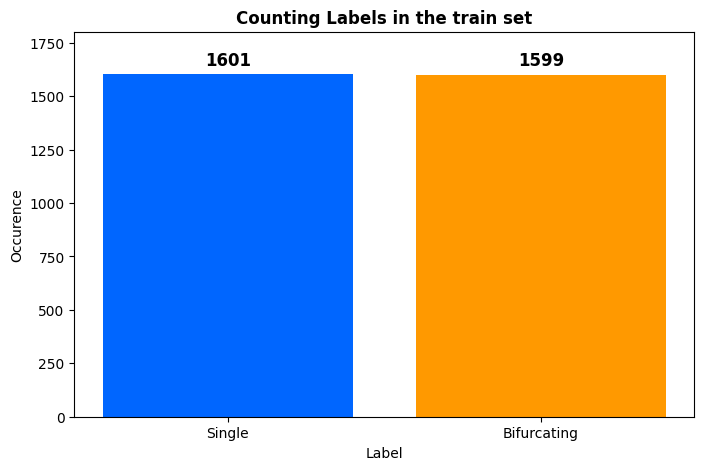

In [34]:
check_label_balance(global_var['train_path'])

## Scatter plot

In [35]:
def get_scatter_data(file_path):
    """
    Get scatter data for pressures and WSS.

    Args:
        file_path (str): Path to the HDF5 file.

    Returns:
        tuple: Lists of pressures and WSS for single and bifurcating samples.
    """
    single_pressures = []
    single_wss = []
    bifurcating_pressures = []
    bifurcating_wss = []

    with h5py.File(file_path, 'r') as file:
        for sample in tqdm(list(file.keys()),desc = "Getting scatter data"):
            # Shift to mPa (millPascal)
            pressure = file[sample]['pressure'][()]
            mean_pressure = np.array(pressure).mean() * 1e-3
            mean_wss = np.array(file[sample]['wss'][()]).mean()

            if file[sample]['label'][0] == 0:
                single_pressures.append(mean_pressure)
                single_wss.append(mean_wss)
            else:
                bifurcating_pressures.append(mean_pressure)
                bifurcating_wss.append(mean_wss)

    pressures = [single_pressures,bifurcating_pressures]
    wss = [single_wss,bifurcating_wss]

    return pressures,wss

In [36]:
def scatter_plot(file_path):
    """
    Create a scatter plot between mean WSS and Pressure
    for single and bifurcating samples.

    Args:
        file_path (str): Path to the HDF5 file.
    """
    pressures,wss = get_scatter_data(file_path)

    fig, ax = plt.subplots(figsize = (10,7))

    ax.scatter(
        pressures[0],
        wss[0],
        label = 'Single',
        alpha = 0.3
     )
    ax.scatter(
        pressures[1],
        wss[1],
        label = 'Bifurcating',
        alpha = 0.3
     )

    ax.set_xlabel('Mean Pressure')
    ax.set_ylabel('Mean WSS (Wall Shear Stress)')
    ax.set_title('Scatterplot between mean WSS e Pressure', weight = 'bold')

    ax.legend()
    plt.show()

Getting scatter data:   0%|          | 0/3200 [00:00<?, ?it/s]

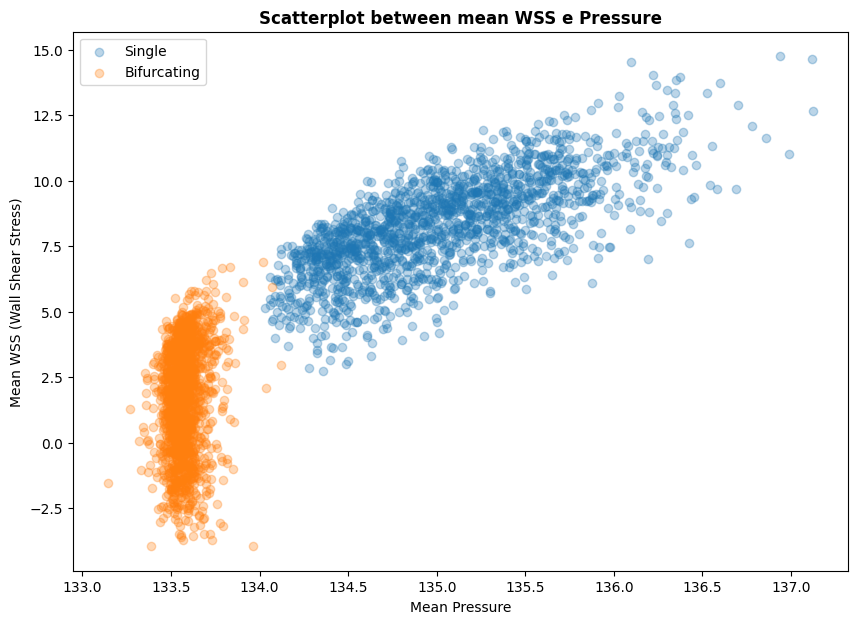

In [37]:
scatter_plot(global_var['train_path'])

# Baseline

# GATr primitives

## Example data

In [38]:
# Get some data to try primitive blocks
data_module.setup()
try_train_loader = data_module.train_dataloader()
input_mv, labels = next(iter(try_train_loader))

print("[LOG] Input mv: ", input_mv.shape)
print("[LOG] Labels: ", labels.shape)

[LOG] Input mv:  torch.Size([32, 5466, 4, 16])
[LOG] Labels:  torch.Size([32, 1])


## Equilinear layer

In [39]:
def get_blade():
    """
    Get a matrix operator to obtain the bladed multivector.

    Returns:
        torch.Tensor: Blade matrix.
    """
    mv_dimension = global_var['ga_dimension']
    blade_shape = (mv_dimension,mv_dimension)

    coordinates = []
    start = 0
    for length in global_var['grade_components']:
        coordinates.append(list(range(start, start + length)))
        start += length

    coord_permutations = [
        [[0,1]],
        [[2,5],[3,6],[4,7]],
        [[8,11],[9,12],[10,13]],
        [[14,15]]
     ]
    blade_mask = []

    w_dimension = len(global_var['grade_components'])
    for k_grade in range(w_dimension):
        w_blade = torch.zeros(blade_shape)
        for coordinate in coordinates[k_grade]:
            w_blade[coordinate, coordinate] = 1.0
        blade_mask.append(w_blade.unsqueeze(0))

    v_dimension = len(global_var['grade_components']) - 1
    for k_grade in range(v_dimension):
        v_blade = torch.zeros(blade_shape)
        for coord_to,coord_from in coord_permutations[k_grade]:
            v_blade[coord_from, coord_to] = 1.0
        blade_mask.append(v_blade.unsqueeze(0))

    return torch.cat(blade_mask,dim = 0)

In [40]:
# Show the effect of the blade on mv
blade = get_blade()
wss_mv = input_mv[0,0,0]

print("[LOG] Initial multivector for Position: \n\t",end = "")
initial_mv = []
for wss in wss_mv:
    wss = round(wss.item(),4)
    initial_mv.append(wss)
print(initial_mv)

bladed_input = blade * wss_mv
blade_w_range = len(global_var['grade_components'])
bladed_mv = []
for blade_w in range(blade_w_range):
    bladed_mv_w = []
    for coord in range(global_var['ga_dimension']):
        blade_elem = bladed_input[blade_w,coord,coord].item()
        rounded_blade = round(blade_elem,4)
        bladed_mv_w.append(rounded_blade)
    bladed_mv.append(bladed_mv_w)

coord_permutations = [
        [[0,1]],
        [[2,5],[3,6],[4,7]],
        [[8,11],[9,12],[10,13]],
        [[14,15]]
     ]

blade_v_range = bladed_input.shape[0]
for blade_v in range(blade_w,blade_v_range):
    bladed_mv_v = []
    for coord in range(global_var['ga_dimension']):
        if coord == 0:
            x = coord_permutations[0][0][1]
            y = coord_permutations[0][0][0]
        if coord >= 2 and coord <= 4:
            x = coord_permutations[1][1]
            y = coord_permutations[1][0]
        if coord >= 8 and coord <= 10:
            x = coord_permutations[2][1]
            y = coord_permutations[2][0]
        if coord == 14:
            x = coord_permutations[3][0][1]
            y = coord_permutations[3][0][0]
        else:
            x = coord
            y = coord

        blade_elem = bladed_input[blade_v,x,y].item()
        rounded_blade = round(blade_elem,4)
        bladed_mv_v.append(rounded_blade)
    bladed_mv.append(bladed_mv_v)

for blade_idx in range(len(bladed_mv)):
    bladed_output = bladed_mv[blade_idx]
    if not all(x == 0 for x in bladed_output):
        if blade_idx < 5:
            log_str = f"[LOG] Blade w grade {blade_idx}: \n\t"
            print(log_str,end = "")
        else:
            log_str = f"[LOG] Blade v grade {blade_idx - blade_w_range}: \n\t"
            print(log_str,end = "")
        print(bladed_output)

[LOG] Initial multivector for Position: 
	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.3645, 0.6627, -0.0321, 1.0, 0.0]
[LOG] Blade w grade 3: 
	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.3645, 0.6627, -0.0321, 1.0, 0.0]
[LOG] Blade v grade 4: 
	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 1.0, 0.0]


In [41]:
class EquiLinearLayer(nn.Module):
    """
    Equivariant Linear Layer.

    Args:
        input_mv_channels (int): Number of input multivector channels.
        hidden_mv_dim (int): Dimension of the hidden multivector.
        blade (torch.Tensor): Blade matrix.
        blade_len (int): Length of the blade.

    Attributes:
        blade (torch.Tensor): Blade matrix.
        weights (nn.Parameter): Learnable weights.
    """
    def __init__(self,input_mv_channels,hidden_mv_dim,blade,blade_len):
        super(EquiLinearLayer,self).__init__()
        self.blade = blade
        self.weights = nn.Parameter(
            torch.rand(hidden_mv_dim,input_mv_channels,blade_len)
         )

    def forward(self,x):
        output_mv = torch.einsum(
            "j i b, b x y, ... i x -> ... j y",
            self.weights,
            self.blade,
            x
         )
        return output_mv

In [42]:
blade = get_blade()
blade_len = blade.shape[0]

equi_linear = EquiLinearLayer(
    input_mv_channels = input_mv.shape[-2],
    hidden_mv_dim = global_var['hidden_dim'],
    blade = blade,
    blade_len = blade_len
)

In [43]:
equi_linear_input = input_mv
equi_linear_input_shape = equi_linear_input.shape
print(f"[LOG] Input of equilinear layer: {equi_linear_input_shape}")

equi_linear_output = equi_linear(equi_linear_input)
equi_linear_output_shape = equi_linear_output.shape
print(f"[LOG] Output of equilinear layer: {equi_linear_output_shape}")

data_sanity_check(equi_linear_input,equi_linear_output)

[LOG] Input of equilinear layer: torch.Size([32, 5466, 4, 16])
[LOG] Output of equilinear layer: torch.Size([32, 5466, 16, 16])
[LOG] Data are free of infinite or Nan values ✔


## Equilinear norm

In [82]:
def inner_product(x,y):
    product_basis = torch.load("geometric_product.pt").to(torch.float32).to_dense()

    reversal_flat = torch.ones(16)
    reversal_flat[5:15] = -1

    inner_product_mask = (torch.diag(product_basis[0]) * reversal_flat).bool()

    x = x[..., inner_product_mask]
    y = y[..., inner_product_mask]

    geometric_product = torch.einsum(
        "... i, ... i -> ...", x, y
    )

    geometric_product = geometric_product.unsqueeze(-1)

    return geometric_product

In [83]:
class EquilinearNormLayer(nn.Module):
    def __init__(self):
        super(EquilinearNormLayer,self).__init__()

    def forward(self, x):
        mv_inner_product = inner_product(x,x)
        squared_norms = torch.mean(mv_inner_product, dim=-2, keepdim=True)

        # Rescale inputs
        outputs = x / torch.sqrt(squared_norms)

        return outputs

In [84]:
equi_norm = EquilinearNormLayer()

In [117]:
equi_norm_input = equi_linear_output
equi_norm_input_shape = equi_norm_input.shape
a = torch.mean(inner_product(equi_norm_input,equi_norm_input), dim = -2)
print(f"Input of equilinear norm layer: {equi_norm_input_shape}")
print(f"Input mv channel norm: ", torch.mean(a).item())

equi_norm_output = equi_norm(equi_norm_input)
equi_norm_output_shape = equi_norm_output.shape
print(f"Output of equilinear layer: {equi_norm_output_shape}")
a = torch.mean(inner_product(equi_norm_output,equi_norm_output), dim = -2)
print(f"Output mv channel norm: ", torch.mean(a).item())

data_sanity_check(equi_norm_input,equi_norm_output)

Input of equilinear norm layer: torch.Size([32, 5466, 16, 16])
Input mv channel norm:  6777729536.0
Output of equilinear layer: torch.Size([32, 5466, 16, 16])
Output mv channel norm:  1.0
[LOG] Data are free of infinite or Nan values ✔


## Geometric attention layer

## Geometric bilinear layer

## Gated GELU

In [125]:
class GatedGELU(nn.Module):
    def __init__(self):
        super(GatedGELU,self).__init__()
        self.gelu = nn.GELU()

    def forward(self,x):
        gates = x[...,[0]]
        weights = self.gelu(gates)
        outputs = weights * x
        return outputs

In [126]:
gated_gelu = GatedGELU()

In [128]:
gated_gelu_input = equi_norm_output
gated_gelu_input_shape = gated_gelu_input.shape
print(f"Input of equilinear norm layer: {gated_gelu_input_shape}")

gated_gelu_output = gated_gelu(gated_gelu_input)
gated_gelu_output_shape = gated_gelu_output.shape
print(f"Output of equilinear layer: {gated_gelu_output_shape}")

data_sanity_check(equi_norm_input,equi_norm_output)

Input of equilinear norm layer: torch.Size([32, 5466, 16, 16])
Output of equilinear layer: torch.Size([32, 5466, 16, 16])
[LOG] Data are free of infinite or Nan values ✔


# GATr architecture

# Train

# Evaluation